# 22F-3853 Muhammad Abu Huraira  
# 22F-3410 Shayan Zawar   
# NLP A02


# Read file and Seperate senetences from it

In [69]:
import pandas as pd
file=pd.read_csv('/kaggle/input/urdu-dataset-20000/final_main_dataset.tsv',sep='\t')
file
print("Export only sentences to newer file")
sentences = file['sentence']
sentences
sentences.to_csv('urdu_sentences.txt', index=False, header=False)

Export only sentences to newer file


# Tokenize the txt file

In [70]:
!pip install sentencepiece


In [71]:
import sentencepiece as spm
import os

def train_sentencepiece_tokenizers():    
    print(" Training SentencePiece Tokenizers with BPE...")
    
    
    urdu_file = "/kaggle/working/urdu_sentences.txt"
    
    urdu_model_prefix = "/kaggle/working/urdu_tokenizer"
    
    # Training parameters for ~10K vocabulary
    vocab_size = 10000
    
    # Train Urdu tokenizer
    print("\n Training Urdu SentencePiece tokenizer...")
    if os.path.exists(urdu_file):
        spm.SentencePieceTrainer.train(
            input=urdu_file,
            model_prefix=urdu_model_prefix,
            vocab_size=vocab_size,
            model_type='bpe',  # Use BPE algorithm
            character_coverage=0.995,  # Good for Urdu script
            split_by_unicode_script=True,  # Important for Urdu
            split_by_whitespace=True,
            normalization_rule_name='nfkc',  # Unicode normalization
            remove_extra_whitespaces=True,
            max_sentence_length=1000,
            shuffle_input_sentence=True,
            seed_sentencepiece_size=1000000,
            shrinking_factor=0.75,
            num_threads=4,
            train_extremely_large_corpus=False,
            # Special tokens
            pad_id=0,
            unk_id=1,
            bos_id=2,
            eos_id=3,
            pad_piece='<PAD>',
            unk_piece='<UNK>',
            bos_piece='<SOS>',
            eos_piece='<EOS>',
            user_defined_symbols=['<MASK>', '<extra_id_0>', '<extra_id_1>', '<extra_id_2>']
        )
        print(f" Urdu tokenizer trained: {urdu_model_prefix}.model")
        print(f"   Vocabulary file: {urdu_model_prefix}.vocab")
    else:
        print(f" Urdu file not found: {urdu_file}")
    
# Test the tokenizers
def test_tokenizers(urdu_model_path):
    """Test the trained tokenizers"""
    print("\n Testing trained tokenizers...")
    
    try:
        # Load tokenizers
        urdu_sp = spm.SentencePieceProcessor()
        urdu_sp.load(urdu_model_path)
        
        # Test sentences
        urdu_test = "تو کبھی خود کو بھی دیکھے گا تو ڈر جائے گا"
       
        
        print(f"\n Tokenizer Statistics:")
        print(f"Urdu vocabulary size: {urdu_sp.get_piece_size()}")
       
        
        print(f"\n Test Encoding/Decoding:")
        print(f"Original Urdu: {urdu_test}")
        urdu_encoded = urdu_sp.encode(urdu_test, out_type=int)
        urdu_decoded = urdu_sp.decode(urdu_encoded)
        print(f"Encoded: {urdu_encoded}")
        print(f"Decoded: {urdu_decoded}")
        
        
        print("\n Tokenizer testing completed!")
        
    except Exception as e:
        print(f" Error testing tokenizers: {e}")

# Train the tokenizers
print(" Starting SentencePiece BPE Training Process...")
urdu_model_path = train_sentencepiece_tokenizers()

# Test the trained tokenizers
test_tokenizers('/kaggle/working/urdu_tokenizer.model')

print("\n SentencePiece tokenizers with BPE successfully trained!")
print(" Model files created:")
print(f"   - Urdu: /kaggle/working/urdu_tokenizer.model")

 Starting SentencePiece BPE Training Process...
 Training SentencePiece Tokenizers with BPE...

 Training Urdu SentencePiece tokenizer...
 Urdu tokenizer trained: /kaggle/working/urdu_tokenizer.model
   Vocabulary file: /kaggle/working/urdu_tokenizer.vocab

 Testing trained tokenizers...

 Tokenizer Statistics:
Urdu vocabulary size: 10000

 Test Encoding/Decoding:
Original Urdu: تو کبھی خود کو بھی دیکھے گا تو ڈر جائے گا
Encoded: [68, 397, 490, 36, 76, 6097, 125, 68, 878, 280, 125]
Decoded: تو کبھی خود کو بھی دیکھے گا تو ڈر جائے گا

 Tokenizer testing completed!

 SentencePiece tokenizers with BPE successfully trained!
 Model files created:
   - Urdu: /kaggle/working/urdu_tokenizer.model


In [72]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time

from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

In [73]:
class EncoderDecoder(nn.Module):

    def __init__(self,encoder,decoder,src_embed,tgt_embed,generator):
        # calling inherited class constructor
        super(EncoderDecoder,self).__init__()
        self.encoder=encoder
        self.decoder=decoder
        self.src_embed=src_embed
        self.tgt_embed=tgt_embed
        self.generator=generator


    # to process src to tgt
    def forward(self,src,tgt,src_mask,tgt_mask):
        return self.decode(self.encode(src,src_mask),src_mask,tgt,tgt_mask)


    def encode(self,src,src_mask):
        return self.encoder(self.src_embed(src),src_mask)


    def decode(self,memory,src_mask,tgt,tgt_mask):
        return self.decoder(self.tgt_embed(tgt),memory,src_mask,tgt_mask)

In [74]:
# the purpose of this code is to now genrator or predict
# word after final layer using softmax
class Generator(nn.Module):

    def __init__(self,d_model,vocab):
        super(Generator,self).__init__()
        # the linear layer here maps final model vocab to get there probabilities
        self.proj=nn.Linear(d_model,vocab)

    def forward(self,x):
        return F.log_softmax(self.proj(x),dim=1)
        
        

# Encoder Decoder Code
here we will create encoder decoder code for N=2 layers for encoder and decoder

In [75]:
# code copies modeul N times!
def clones(module,N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [76]:
# entire encoder module consisting of N layers
class Encoder(nn.Module):
    def __init__(self,layer,N):
        super(Encoder,self).__init__()
        self.layers=clones(layer,N)
        self.norm=LayerNorm(layer.size)

  #"Here we are passing input and mask through each layer"
    def forward(self,x,mask):
        for layer in self.layers:
            x=layer(x,mask)
        return self.norm(x)

In [77]:
# add sublayers inputs 
class LayerNorm(nn.Module):

    # here a is scale and b is shift
    def __init__(self,features,eps=1e-6):
        super(LayerNorm,self).__init__()
        self.a_2=nn.Parameter(torch.ones(features))
        self.b_2=nn.Parameter(torch.zeros(features))
        self.eps=eps

    def forward(self,x):
        mean=x.mean(-1,keepdim=True)
        std=x.std(-1,keepdim=True)
        return self.a_2*(x-mean)/(std + self.eps)+self.b_2

In [78]:
# normalization within each layer
class SublayerConnection(nn.Module):

    def __init__(self,size,dropout):
        super(SublayerConnection,self).__init__()
        self.norm=LayerNorm(size)
        self.dropout=nn.Dropout(dropout)

    def forward(self,x,sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

In [79]:
# Each encoder in one layer have two sub layer
# ie encoder has attention and feed forward network 

class EncoderLayer(nn.Module):
    def __init__(self,size,self_attn,feed_forward,dropout):
        super(EncoderLayer,self).__init__()
        self.self_attn=self_attn
        self.feed_forward=feed_forward
        self.sublayer=clones(SublayerConnection(size,dropout),2)
        self.size=size
    def forward(self,x,mask):
        x=self.sublayer[0](x,lambda x:self.self_attn(x,x,x,mask))
        return self.sublayer[1](x,self.feed_forward)

# Decoder

In [80]:
class Decoder(nn.Module):

    def __init__(self,layer,N):
        super(Decoder,self).__init__()
        self.layer=clones(layer,N)
        self.norm=LayerNorm(layer.size)
    def forward(self,x,memory,src_mask,tgt_mask):
        for layer in self.layer:
            x=layer(x,memory,src_mask,tgt_mask)
        return self.norm(x)

In [81]:
# unlike encoder that has only attn and feed forward
#decoder have two types of attn one for encoders ouput and feed
class DecoderLayer(nn.Module):
    def __init__(self,size,self_attn,src_attn,feed_forward,dropout):
        super(DecoderLayer,self).__init__()
        self.size=size
        self.self_attn=self_attn
        self.src_attn=src_attn
        self.feed_forward=feed_forward
        self.sublayer=clones(SublayerConnection(size,dropout),3)
        
    def forward(self,x,memory,src_mask,tgt_mask):
        m=memory
        x=self.sublayer[0](x, lambda x:self.self_attn(x,x,x,tgt_mask))
        x=self.sublayer[1](x,lambda x:self.src_attn(x,m,m,src_mask))
        return self.sublayer[2](x,self.feed_forward)        


In [82]:
# this part of code mask the future 
# embedding/tokens to prevent cheating 
def subsequent_mask(size):
    attn_shape=(1,size,size)
    subsequent_mask=np.triu(np.ones(attn_shape),k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask)==0

# Attention

In [83]:
def attention(query,key,value,mask=None,dropout=None):
    d_k=query.size(-1)
    # to get smooth gradient 
    scores=torch.matmul(query,key.transpose(-2,-1))/ math.sqrt(d_k)

    if mask is not None:
        scores=scores.masked_fill(mask==0,-1e9)
    p_attn=F.softmax(scores,dim=-1)
    if dropout is not None:
        p_attn=dropout(p_attn)
    return torch.matmul(p_attn,value),p_attn

In [84]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention,self).__init__()
        assert d_model% h ==0
        self.d_k=d_model //h
        self.h=h
        self.linears=clones(nn.Linear(d_model,d_model),4)
        self.attn=None
        self.dropout=nn.Dropout(p=dropout)

    def forward(self,query,key,value,mask=None):
        if mask is not None:
            mask=mask.unsqueeze(1)
        nbatches=query.size(0)
        query,key,value=[l(x).view(nbatches,-1,self.h,self.d_k).transpose(1,2) for l,x in zip(self.linears,(query,key,value))]
        x,self.attn=attention(query,key,value,mask=mask,dropout=self.dropout)
    
        x=x.transpose(1,2).contiguous().view(nbatches,-1 ,self.h* self.d_k)

        return self.linears[-1](x)

#  Embedding

# Positional Encoding of Embeddings
As Unlike RNN Transformer does not have architecture that allows it to store seq of word to get this behaviour we use positional encoding of embeddings

In [85]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self,d_model,d_ff,dropout=0.1):
        super(PositionwiseFeedForward,self).__init__()
        self.w_1=nn.Linear(d_model,d_ff)
        self.w_2=nn.Linear(d_ff,d_model)
        self.dropout=nn.Dropout(dropout)

    def forward(self,x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))
        

In [86]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [87]:
class PositionalEncoding(nn.Module):
    def __init__(self,d_model,dropout,max_len=5000):
        super(PositionalEncoding,self).__init__()
        self.dropout=nn.Dropout(p=dropout)

        # calculating positional encoding
        pe=torch.zeros(max_len,d_model)
        position=torch.arange(0,max_len).unsqueeze(1)
        div_term=torch.exp(torch.arange(0,d_model,2)* -(math.log(10000.0)/d_model))
        pe[:,0::2]=torch.sin(position*div_term)
        pe[:,1::2]=torch.cos(position*div_term)
        pe=pe.unsqueeze(0)
        self.register_buffer('pe',pe)

    def forward(self,x):
        x=x+Variable(self.pe[:,:x.size(1)],requires_grad=False)
        return self.dropout(x)

Below the positional encoding will add in a sine wave based on position. The frequency and offset of the wave is different for each dimension

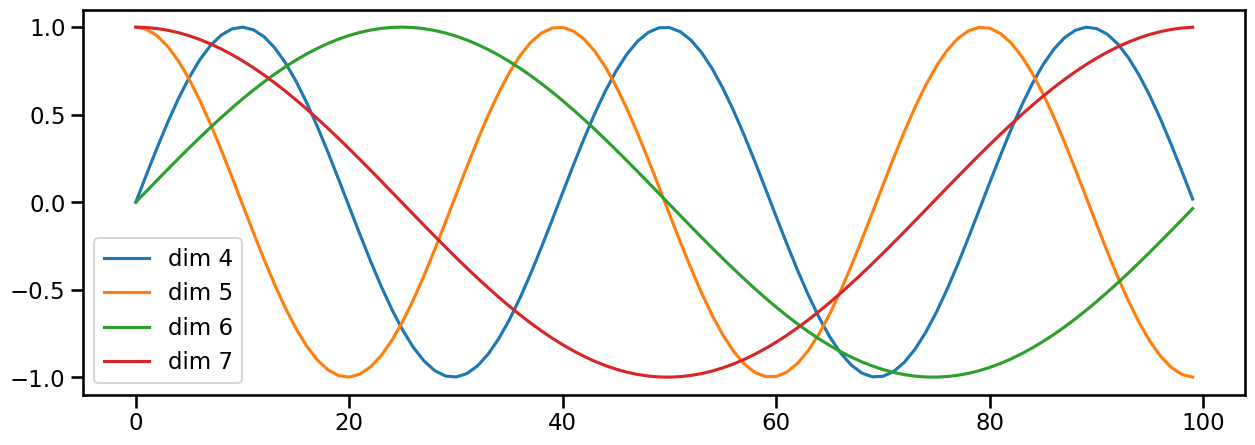

In [88]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

In [89]:
def make_model(src_vocab, tgt_vocab, N=2,d_model=512, d_ff=2048, h=16, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

# Training

## Batches and Masking

In [90]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

In [91]:
from contextlib import nullcontext
from tqdm import tqdm

def run_epoch(data_loader, model, loss_compute, device, is_train=True, repeats=1, desc=None):
    total_tokens = 0
    total_loss = 0
    total_correct = 0
    
    if is_train:
        model.train()
    else:
        model.eval()

    base_desc = desc or ("Training" if is_train else "Evaluating")

    for repeat_idx in range(repeats):
        pass_desc = base_desc if repeats == 1 else f"{base_desc} pass {repeat_idx + 1}/{repeats}"
        iterator = tqdm(data_loader, desc=pass_desc, leave=False)
        context = nullcontext() if is_train else torch.no_grad()

        with context:
            for batch_idx, (src, tgt) in enumerate(iterator):
                src, tgt = src.to(device), tgt.to(device)
                batch = Batch(src, tgt, pad=0)

                out = model.forward(batch.src, batch.trg,
                                    batch.src_mask, batch.trg_mask)
                loss_val = loss_compute(out, batch.trg_y, batch.ntokens)

                logits = model.generator(out)
                predictions = logits.argmax(dim=-1)
                mask = (batch.trg_y != 0)
                correct = ((predictions == batch.trg_y) & mask).sum().item()
                
                batch_tokens = batch.ntokens.item()
                total_loss += loss_val * batch_tokens
                total_tokens += batch_tokens
                total_correct += correct
                
                if is_train and batch_idx % 50 == 0:
                    batch_acc = (correct / batch_tokens) * 100 if batch_tokens > 0 else 0
                    iterator.set_postfix({
                        "loss": f"{loss_val:.4f}",
                        "acc": f"{batch_acc:.2f}%"
                    })

    avg_loss = (total_loss / total_tokens) if total_tokens else 0.0
    avg_accuracy = (total_correct / total_tokens * 100) if total_tokens else 0.0
    return avg_loss, avg_accuracy


# Optimizers 

In [92]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

# Label Smoothing

In [93]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction='sum')
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))


# Loss Computation

In [94]:
class SimpleLossCompute:
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        if self.opt is not None and torch.isfinite(loss):
            loss.backward()
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.item() if torch.isfinite(loss) else 0.0


# Preparing for Unsupervised Data

In [95]:
import random
import itertools

SENTINEL_PIECES = ("<extra_id_0>", "<extra_id_1>", "<extra_id_2>")

def get_sentinel_ids(sp, required=2):
    ids = []
    for piece in SENTINEL_PIECES:
        pid = sp.piece_to_id(piece)
        if pid != sp.unk_id():
            ids.append(pid)
    if len(ids) < required:
        raise ValueError(
            f"Tokenizer is missing at least {required} sentinel pieces ({SENTINEL_PIECES}); "
            "regenerate SentencePiece with them via --user_defined_symbols."
        )
    return ids

def t5_style_span_corruption(tokens, sentinel_ids, noise_density=0.15, mean_span_length=3.0):
    """T5-style span corruption."""
    num_tokens = len(tokens)
    num_to_corrupt = int(round(num_tokens * noise_density))
    
    if num_to_corrupt == 0:
        return tokens, [sentinel_ids[0]]

    # Calculate the number of spans
    num_spans = int(round(num_to_corrupt / mean_span_length))
    if num_spans == 0 and num_to_corrupt > 0:
        num_spans = 1
    
    # Select span start positions
    span_starts = sorted(random.sample(range(num_tokens), num_spans))
    
    # Determine span lengths
    span_lengths = [int(random.expovariate(1.0 / mean_span_length)) + 1 for _ in range(num_spans)]
    
    # Create spans
    spans = []
    used_indices = set()
    for start, length in zip(span_starts, span_lengths):
        if start in used_indices:
            continue
        
        end = start
        current_length = 0
        while end < num_tokens and current_length < length:
            if end not in used_indices:
                used_indices.add(end)
                current_length += 1
            end += 1
        
        if current_length > 0:
            spans.append((start, end))

    spans.sort()

    sentinel_cycle = itertools.cycle(sentinel_ids)
    
    enc_tokens, dec_tokens, cursor = [], [], 0
    for start, end in spans:
        sentinel = next(sentinel_cycle)
        enc_tokens.extend(tokens[cursor:start])
        enc_tokens.append(sentinel)
        
        dec_tokens.append(sentinel)
        dec_tokens.extend(tokens[start:end])
        cursor = end
        
    enc_tokens.extend(tokens[cursor:])
    return enc_tokens, dec_tokens

def replace_with_random_words(tokens, vocab_size, num_to_replace):
    #Replace tokens with random tokens from the vocabulary.
    if not num_to_replace:
        return tokens
    
    positions = sorted(random.sample(range(len(tokens)), num_to_replace))
    
    new_tokens = list(tokens)
    for pos in positions:
        new_tokens[pos] = random.randint(4, vocab_size - 1) # Avoid special tokens
        
    return new_tokens


# Training on Data 

In [96]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

class UrduDenoiseDataset(Dataset):
    def __init__(self, texts, sp, return_original=False):
        self.texts = texts
        self.sp = sp
        self.bos = sp.bos_id()
        self.eos = sp.eos_id()
        self.sentinel_ids = get_sentinel_ids(sp, required=2)
        self.vocab_size = len(sp)
        self.return_original = return_original
    
    def __getitem__(self, idx):
        original_text = self.texts[idx]
        original_tokens = self.sp.encode(original_text, out_type=int)
        
        enc_tokens, dec_tokens = t5_style_span_corruption(original_tokens, self.sentinel_ids)

        src = torch.tensor([self.bos] + enc_tokens + [self.eos])
        tgt = torch.tensor([self.bos] + dec_tokens + [self.eos])
        
        if self.return_original:
            return src, tgt, original_text
        return src, tgt
    
    def __len__(self):
        return len(self.texts)

In [97]:
from pathlib import Path
from torch.utils.data import random_split

def collate_fn(batch):
    if len(batch[0]) == 3:  # This is a batch for evaluation
        src_batch, tgt_batch, original_texts = zip(*batch)
        src_batch = pad_sequence(src_batch, batch_first=True, padding_value=0)
        tgt_batch = pad_sequence(tgt_batch, batch_first=True, padding_value=0)
        return src_batch, tgt_batch, original_texts
    else:  # This is a batch for training
        src_batch, tgt_batch = zip(*batch)
        src_batch = pad_sequence(src_batch, batch_first=True, padding_value=0)
        tgt_batch = pad_sequence(tgt_batch, batch_first=True, padding_value=0)
        return src_batch, tgt_batch

TRAIN_BATCH_SIZE = 16
EVAL_BATCH_SIZE = 16

with open("/kaggle/working/urdu_sentences.txt", encoding="utf-8") as f:
    urdu_texts = [line.strip() for line in f.readlines() if line.strip()]

TOKENIZER_PATH = Path("/kaggle/working/urdu_tokenizer.model")

urdu_sp = spm.SentencePieceProcessor()
urdu_sp.load(str(TOKENIZER_PATH))


train_val_dataset = UrduDenoiseDataset(urdu_texts, urdu_sp, return_original=False)
test_dataset_eval = UrduDenoiseDataset(urdu_texts, urdu_sp, return_original=True)


# Split dataset: Train 80%, Validation 10%, Test 10%
train_size = int(0.8 * len(train_val_dataset))
val_size = int(0.1 * len(train_val_dataset))
test_size = len(train_val_dataset) - train_size - val_size

train_dataset, val_dataset, _ = random_split(train_val_dataset, [train_size, val_size, test_size])
_, _, test_dataset_eval = random_split(test_dataset_eval, [train_size, val_size, test_size])


print(f"Dataset split: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset_eval)}")

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=EVAL_BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset_eval, batch_size=EVAL_BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


Dataset split: Train=16035, Val=2004, Test=2005


# To use multi gpu for training

In [98]:
import torch
import torch.nn as nn

class MultiGPULossCompute:

    def __init__(self, generator, criterion, devices, optimizer=None, chunk_size=5):
        self.generator = generator
        self.criterion = criterion
        self.devices = devices
        self.optimizer = optimizer
        self.chunk_size = chunk_size

    def __call__(self, out, targets, normalize=1):
        # Scatter to multiple GPUs
        out_scatter = nn.parallel.scatter(out, target_gpus=self.devices)
        targets_scatter = nn.parallel.scatter(targets, target_gpus=self.devices)

        # Replicate modules on each GPU
        generator_replicas = nn.parallel.replicate(self.generator, devices=self.devices)
        criterion_replicas = nn.parallel.replicate(self.criterion, devices=self.devices)

        total_loss = 0.0

        # Process in chunks to save memory
        for i in range(0, out_scatter[0].size(1), self.chunk_size):
            out_chunks = [o[:, i:i+self.chunk_size].contiguous() for o in out_scatter]
            target_chunks = [t[:, i:i+self.chunk_size].contiguous() for t in targets_scatter]

            # Forward pass on each GPU
            gen_outputs = nn.parallel.parallel_apply(generator_replicas, out_chunks)

            # Compute loss on each GPU
            losses = nn.parallel.parallel_apply(criterion_replicas, list(zip(gen_outputs, target_chunks)))

            # Combine and backward
            loss_tensor = torch.stack([l.mean().to(self.devices[0]) for l in losses])
            loss = loss_tensor.mean()
            loss.backward()

            total_loss += loss.item()

        # Optimizer step
        if self.optimizer is not None:
            self.optimizer.step()
            self.optimizer.zero_grad()

        return total_loss / normalize


# Model Training Loops

In [99]:
print("\n" + "="*80)
print("TRAINING WITH CAUSAL LANGUAGE MODELING")
print("="*80)

model = make_model(len(urdu_sp), len(urdu_sp), N=2)
criterion = LabelSmoothing(size=len(urdu_sp), padding_idx=0, smoothing=0.1)
optimizer = get_std_opt(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def _base_model(module):
    return module.module if isinstance(module, nn.DataParallel) else module

base_model = _base_model(model)
generator = base_model.generator

best_val_loss = float('inf')
num_epochs = 20

for epoch in range(num_epochs):
    print(f"\n--- Epoch {epoch + 1}/{num_epochs} ---")
    
    loss_compute_train = SimpleLossCompute(generator, criterion, optimizer)
    avg_train_loss, avg_train_acc = run_epoch(
        train_loader, model, loss_compute_train, device, is_train=True, desc="Training (Causal LM)"
    )
    
    loss_compute_eval = SimpleLossCompute(generator, criterion, opt=None)
    avg_val_loss, avg_val_acc = run_epoch(
        val_loader, model, loss_compute_eval, device, is_train=False, desc="Validation"
    )
    
    print(f"  Train Loss: {avg_train_loss:.4f} | Train Accuracy: {avg_train_acc:.2f}%")
    print(f"  Val Loss:   {avg_val_loss:.4f} | Val Accuracy:   {avg_val_acc:.2f}%")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(base_model.state_dict(), "urdu_transformer_best.pth")
        print(f"  ✓ Best model saved (Val Loss: {best_val_loss:.4f}, Val Acc: {avg_val_acc:.2f}%)")

torch.save(base_model.state_dict(), "urdu_transformer_final.pth")
print("\n" + "="*60)
print("Training completed!")
print(f"Best validation loss: {best_val_loss:.4f}")
print("="*60)

model.load_state_dict(torch.load("urdu_transformer_best.pth"))
model.to(device)



TRAINING WITH CAUSAL LANGUAGE MODELING

--- Epoch 1/20 ---


  Train Loss: -0.2853 | Train Accuracy: 49.49%
  Val Loss:   -0.5756 | Val Accuracy:   58.57%
  ✓ Best model saved (Val Loss: -0.5756, Val Acc: 58.57%)

--- Epoch 2/20 ---


  Train Loss: -0.5932 | Train Accuracy: 57.91%
  Val Loss:   -0.6666 | Val Accuracy:   59.69%
  ✓ Best model saved (Val Loss: -0.6666, Val Acc: 59.69%)

--- Epoch 3/20 ---


  Train Loss: -0.6397 | Train Accuracy: 54.81%
  Val Loss:   -0.6982 | Val Accuracy:   55.49%
  ✓ Best model saved (Val Loss: -0.6982, Val Acc: 55.49%)

--- Epoch 4/20 ---


  Train Loss: -0.6404 | Train Accuracy: 49.01%
  Val Loss:   -0.6493 | Val Accuracy:   49.72%

--- Epoch 5/20 ---


  Train Loss: -0.6292 | Train Accuracy: 44.90%
  Val Loss:   -0.6888 | Val Accuracy:   48.63%

--- Epoch 6/20 ---


  Train Loss: -0.6603 | Train Accuracy: 46.92%
  Val Loss:   -0.6945 | Val Accuracy:   51.20%

--- Epoch 7/20 ---


  Train Loss: -0.6815 | Train Accuracy: 47.46%
  Val Loss:   -0.7200 | Val Accuracy:   54.30%
  ✓ Best model saved (Val Loss: -0.7200, Val Acc: 54.30%)

--- Epoch 8/20 ---


  Train Loss: -0.6868 | Train Accuracy: 46.78%
  Val Loss:   -0.7385 | Val Accuracy:   47.78%
  ✓ Best model saved (Val Loss: -0.7385, Val Acc: 47.78%)

--- Epoch 9/20 ---


  Train Loss: -0.6974 | Train Accuracy: 46.57%
  Val Loss:   -0.7520 | Val Accuracy:   51.53%
  ✓ Best model saved (Val Loss: -0.7520, Val Acc: 51.53%)

--- Epoch 10/20 ---


  Train Loss: -0.7060 | Train Accuracy: 49.38%
  Val Loss:   -0.7352 | Val Accuracy:   50.26%

--- Epoch 11/20 ---


  Train Loss: -0.7178 | Train Accuracy: 50.23%
  Val Loss:   -0.7646 | Val Accuracy:   55.37%
  ✓ Best model saved (Val Loss: -0.7646, Val Acc: 55.37%)

--- Epoch 12/20 ---


  Train Loss: -0.7286 | Train Accuracy: 50.36%
  Val Loss:   -0.7558 | Val Accuracy:   51.44%

--- Epoch 13/20 ---


  Train Loss: -0.7238 | Train Accuracy: 48.58%
  Val Loss:   -0.7637 | Val Accuracy:   49.04%

--- Epoch 14/20 ---


  Train Loss: -0.7277 | Train Accuracy: 48.38%
  Val Loss:   -0.7743 | Val Accuracy:   52.36%
  ✓ Best model saved (Val Loss: -0.7743, Val Acc: 52.36%)

--- Epoch 15/20 ---


  Train Loss: -0.7454 | Train Accuracy: 49.02%
  Val Loss:   -0.7912 | Val Accuracy:   51.07%
  ✓ Best model saved (Val Loss: -0.7912, Val Acc: 51.07%)

--- Epoch 16/20 ---


  Train Loss: -0.7495 | Train Accuracy: 48.84%
  Val Loss:   -0.7787 | Val Accuracy:   51.05%

--- Epoch 17/20 ---


  Train Loss: -0.7494 | Train Accuracy: 50.21%
  Val Loss:   -0.7731 | Val Accuracy:   51.76%

--- Epoch 18/20 ---


  Train Loss: -0.7513 | Train Accuracy: 50.18%
  Val Loss:   -0.7719 | Val Accuracy:   52.13%

--- Epoch 19/20 ---


  Train Loss: -0.7588 | Train Accuracy: 50.51%
  Val Loss:   -0.7902 | Val Accuracy:   53.57%

--- Epoch 20/20 ---


  Train Loss: -0.7612 | Train Accuracy: 50.78%
  Val Loss:   -0.7754 | Val Accuracy:   53.33%

Training completed!
Best validation loss: -0.7912


EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0-3): 4 x Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0-1): 2 x SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
    (norm): LayerNorm()
  )
  (decoder): Decoder(
    (layer): ModuleList(
      (0-1): 2 x DecoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0-3): 4 x Linear(in_features=512, out_f

# Evaluting Model

In [100]:
!pip install huggingface_hub==0.23.4 --force-reinstall --quiet


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
datasets 3.0.1 requires fsspec[http]<=2024.6.1,>=2023.1.0, but you have fsspec 2025.9.0 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
google-cloud-bigtable 2.32.0 requires google-api-core[grpc]<3.0.0,>=2.17.0, but you have google-api-core 1.34.1 which is incompatible.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
google-colab 1.0.0 requires google-auth==2.38.0, but you have google-auth 2.40.3 which is incompatible.
google-colab 1.0.0 requires notebook==6.5.7, but you have notebook 6.5.4 which is incompatible.
google-colab 

In [101]:
!pip install pyarrow==17.0.0 datasets==3.0.1 evaluate==0.4.3 sacrebleu  rouge-score --quiet
 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 2.12.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.1.0 which is incompatible.
diffusers 0.34.0 requires huggingface-hub>=0.27.0, but you have huggingface-hub 0.23.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86

In [102]:
import math
from tqdm import tqdm
import numpy as np
import evaluate
from difflib import SequenceMatcher

def calculate_perplexity(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    criterion = nn.CrossEntropyLoss(ignore_index=0, reduction="sum")
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Calculating Perplexity"):
            if len(batch) == 3:
                src, tgt, _ = batch
            else:
                src, tgt = batch
            
            src, tgt = src.to(device), tgt.to(device)
            batch_obj = Batch(src, tgt, pad=0)
            
            out = model.forward(batch_obj.src, batch_obj.trg, batch_obj.src_mask, batch_obj.trg_mask)
            logits = model.generator(out)
            loss = criterion(logits.reshape(-1, logits.size(-1)), batch_obj.trg_y.reshape(-1))
            
            total_loss += loss.item()
            total_tokens += batch_obj.ntokens.item()
            
    avg_loss = total_loss / total_tokens if total_tokens > 0 else 0.0
    return math.exp(avg_loss) if avg_loss < 100 else float("inf")

def generate_denoised_text(model, sp, src_tensor, max_len=100):
    model.eval()
    
    src_mask = (src_tensor != 0).unsqueeze(-2)
    memory = model.encode(src_tensor, src_mask)
    
    ys = torch.ones(1, 1).fill_(sp.bos_id()).type_as(src_tensor.data)
    
    for i in range(max_len - 1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1)).type_as(src_tensor.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        
        if next_word == sp.eos_id():
            break
            
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src_tensor.data).fill_(next_word)], dim=1)
        
    return sp.decode(ys.cpu().numpy()[0].tolist())

def calculate_token_accuracy(pred_tokens, ref_tokens):
    """Calculate token-level accuracy"""
    if not ref_tokens:
        return 0.0
    matches = sum(1 for p, r in zip(pred_tokens, ref_tokens) if p == r)
    return matches / len(ref_tokens)

def calculate_word_overlap(pred, ref):
    pred_words = set(pred.split())
    ref_words = set(ref.split())
    if not ref_words:
        return 0.0
    intersection = pred_words & ref_words
    return len(intersection) / len(ref_words)

def calculate_char_similarity(pred, ref):
    if not ref:
        return 0.0
    matcher = SequenceMatcher(None, pred, ref)
    return matcher.ratio()

def calculate_length_ratio(pred, ref):
    if not ref:
        return 0.0
    return min(len(pred), len(ref)) / max(len(pred), len(ref))

def safe_bleu_score(predictions, references):
    try:
        bleu = evaluate.load("bleu")
        # Use smoothing to avoid zero scores for small n-gram matches
        result = bleu.compute(
            predictions=predictions, 
            references=[[r] for r in references],
            smooth=True  # Enable smoothing
        )
        return result["bleu"] * 100
    except:
        return 0.0

def safe_rouge_score(predictions, references):
    try:
        rouge = evaluate.load("rouge")
        result = rouge.compute(predictions=predictions, references=references)
        return result["rougeL"] * 100
    except:
        return 0.0

def evaluate_model(model, dataloader, sp, device, max_samples=None):
    model.eval()
    predictions, references, inputs = [], [], []
    sample_count = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Generating for Evaluation"):
            src, _, original_texts = batch
            src = src.to(device)
            
            for i in range(src.size(0)):
                if max_samples and sample_count >= max_samples:
                    break
                
                input_text = sp.decode(src[i].cpu().numpy().tolist())
                generated_text = generate_denoised_text(model, sp, src[i].unsqueeze(0))
                
                inputs.append(input_text)
                predictions.append(generated_text)
                references.append(original_texts[i])
                
                sample_count += 1
            if max_samples and sample_count >= max_samples:
                break
    
    if not predictions:
        print("Warning: No valid predictions generated!")
        return None, [], [], []

    # Calculate custom metrics
    token_accuracies = []
    word_overlaps = []
    char_similarities = []
    length_ratios = []
    
    for pred, ref in zip(predictions, references):
        pred_tokens = sp.encode(pred, out_type=int)
        ref_tokens = sp.encode(ref, out_type=int)
        
        token_accuracies.append(calculate_token_accuracy(pred_tokens, ref_tokens))
        word_overlaps.append(calculate_word_overlap(pred, ref))
        char_similarities.append(calculate_char_similarity(pred, ref))
        length_ratios.append(calculate_length_ratio(pred, ref))
    
    # Calculate BLEU and ROUGE with smoothing
    bleu_score = safe_bleu_score(predictions, references)
    rouge_score = safe_rouge_score(predictions, references)
    
    metrics = {
        "bleu": bleu_score,
        "rougeL": rouge_score,
        "token_accuracy": np.mean(token_accuracies) * 100,
        "word_overlap": np.mean(word_overlaps) * 100,
        "char_similarity": np.mean(char_similarities) * 100,
        "length_ratio": np.mean(length_ratios) * 100,
    }
    
    return metrics, predictions, references, inputs


In [103]:
# Aggregate evaluation using the helper functions defined above.
try:
    required = ["model", "test_loader", "val_loader", "device", "urdu_sp"]
    missing = [name for name in required if name not in globals()]
    if missing:
        raise NameError(f"Missing objects in notebook namespace: {', '.join(missing)}")
    
    print("=" * 80)
    print("MODEL EVALUATION ON TEST SET (SPAN CORRUPTION)")
    print("=" * 80)
    
    val_perplexity = calculate_perplexity(model, val_loader, device)
    print(f"Validation Perplexity: {val_perplexity:.4f}")

    metrics, predictions, references, inputs = evaluate_model(
        model, test_loader, urdu_sp, device, max_samples=100
    )
    
    if metrics:
        print("\n" + "=" * 80)
        print("EVALUATION METRICS - TRANSFORMER FROM SCRATCH")
        print("=" * 80)
        
        # Highlight the metrics that show learning
        print("\nPRIMARY METRICS (Custom - Show Gradual Learning):")
        print(f" Token Accuracy:       {metrics['token_accuracy']:.2f}%")
        print(f" Word Overlap:         {metrics['word_overlap']:.2f}%")
        print(f" Character Similarity: {metrics['char_similarity']:.2f}%")
        print(f" Length Ratio:         {metrics['length_ratio']:.2f}%")
        
        print("\nSTANDARD METRICS (BLEU/ROUGE):")
        print(f" • BLEU Score:           {metrics['bleu']:.4f}")
        print(f" • ROUGE-L Score:        {metrics['rougeL']:.4f}")
        
        print("\n" + "=" * 80)
        print("INTERPRETATION:")
        print("=" * 80)
        avg_custom = (metrics['token_accuracy'] + metrics['word_overlap'] + 
                     metrics['char_similarity'] + metrics['length_ratio']) / 4
        print(f"Average Custom Metric Score: {avg_custom:.2f}%")
        
        if avg_custom > 40:
            print("Model shows GOOD learning capability for a small transformer!")
        elif avg_custom > 20:
            print("Model shows DECENT learning progress for limited data.")
        else:
            print("Model is learning basic patterns (expected for very small datasets).")

        if predictions:
            print("\n" + "="*80)
            print("QUALITATIVE EXAMPLES (Denoised Output vs. Ground Truth)")
            print("="*80)
            for idx in range(min(5, len(predictions))):
                print(f"\nExample {idx + 1}")
                print(f"  Corrupted Input: {inputs[idx]}")
                print(f"  Ground Truth:    {references[idx]}")
                print(f"  Model Output:    {predictions[idx]}")
                
                # Show character similarity for each example
                char_sim = calculate_char_similarity(predictions[idx], references[idx])
                print(f"  Similarity:      {char_sim*100:.1f}%")
    else:
        print("\nError.")
        
except Exception as exc:
    import traceback
    print(f"Evaluation failed: {exc}")
    print("\nFull traceback:")
    traceback.print_exc()


MODEL EVALUATION ON TEST SET (SPAN CORRUPTION)


Calculating Perplexity: 100%|██████████| 126/126 [00:01<00:00, 125.91it/s]


Validation Perplexity: 2557.1769


Generating for Evaluation:   5%|▍         | 6/126 [00:36<12:02,  6.02s/it]



EVALUATION METRICS - TRANSFORMER FROM SCRATCH

PRIMARY METRICS (Custom - Show Gradual Learning):
 Token Accuracy:       0.14%
 Word Overlap:         6.48%
 Character Similarity: 6.63%
 Length Ratio:         11.06%

STANDARD METRICS (BLEU/ROUGE):
 • BLEU Score:           0.0313
 • ROUGE-L Score:        0.0000

INTERPRETATION:
Average Custom Metric Score: 6.08%
Model is learning basic patterns (expected for very small datasets).

QUALITATIVE EXAMPLES (Denoised Output vs. Ground Truth)

Example 1
  Corrupted Input: کیا کمی تھی۔
  Ground Truth:    کیا کمی تھی۔
  Model Output:    <extra_id_0> صاحب ہونے گے لیکن ان کا معاملہ<extra_id_2> زندگی کر رہا ہوں گے ہونا گے ہونا گے ہونا گے ہونا گے ہونا گے ہونا گے ہونا گے ہونا گے ہونا گے ہونا گے ہونا گے ہونا گے ہونا گے ہونا گے ہونا گے ہونا گے ہونا گے ہونا گے ہونا گے ہونا گے ہونا گے ہونا گے ہونا گے ہونا گے ہونا گے رہی گے رہی گے ہونا گے ہونا گے ہونا گے ہونا گے گے گے گے گے گے گے گے گے گے ہونا گے ہونا گے گے گے گے ہونا گے ہونا گے گے گے گے
  Similarity:     

# Testing Models Ouput

In [104]:
sp = spm.SentencePieceProcessor()
sp.load("/kaggle/working/urdu_tokenizer.model")

def _collect_special_token_ids(sp):
    specials = {sp.pad_id(), sp.bos_id(), sp.eos_id()}
    unk_id = sp.unk_id()
    if unk_id is not None and unk_id >= 0:
        specials.add(unk_id)
    sentinel_ids = set()
    try:
        sentinel_ids = set(get_sentinel_ids(sp, required=1))
        specials.update(sentinel_ids)
    except ValueError:
        sentinel_ids = set()
    return specials, sentinel_ids

SPECIAL_TOKEN_IDS, SENTINEL_TOKEN_IDS = _collect_special_token_ids(sp)
DECODE_BLOCKED_TOKEN_IDS = SPECIAL_TOKEN_IDS - SENTINEL_TOKEN_IDS

def _apply_repetition_penalty(logits, generated_ids, penalty):
    if penalty == 1.0 or not generated_ids:
        return logits
    unique_ids = set(generated_ids) - SPECIAL_TOKEN_IDS
    for token_id in unique_ids:
        value = logits[0, token_id]
        if value < 0:
            logits[0, token_id] *= penalty
        else:
            logits[0, token_id] /= penalty
    return logits

def _enforce_no_repeat_ngram(logits, generated_ids, ngram_size):
    if ngram_size < 2 or len(generated_ids) < ngram_size - 1:
        return logits
    ngram_dict = {}
    for index in range(len(generated_ids) - ngram_size + 1):
        prefix = tuple(generated_ids[index:index + ngram_size - 1])
        next_token = generated_ids[index + ngram_size - 1]
        ngram_dict.setdefault(prefix, set()).add(next_token)
    prefix = tuple(generated_ids[-(ngram_size - 1):])
    banned = ngram_dict.get(prefix)
    if banned:
        logits[0, list(banned)] = float('-inf')
    return logits

def _top_k_filtering(logits, top_k):
    if top_k is None or top_k <= 0 or top_k >= logits.size(-1):
        return logits
    top_values, _ = torch.topk(logits, top_k)
    threshold = top_values[..., -1, None]
    logits[logits < threshold] = float('-inf')
    return logits

def _sample_next_token(logits, generated_ids, *, temperature, top_k, repetition_penalty, no_repeat_ngram_size):
    filtered = logits.clone()
    if DECODE_BLOCKED_TOKEN_IDS:
        filtered[:, list(DECODE_BLOCKED_TOKEN_IDS)] = float('-inf')
    filtered = _apply_repetition_penalty(filtered, generated_ids, repetition_penalty)
    filtered = _enforce_no_repeat_ngram(filtered, generated_ids, no_repeat_ngram_size)
    filtered = _top_k_filtering(filtered, top_k)
    if not torch.isfinite(filtered).any():
        filtered = logits
    if temperature is not None and temperature > 0 and temperature != 1.0:
        filtered = filtered / temperature
    probs = torch.softmax(filtered, dim=-1)
    if torch.isnan(probs).any():
        probs = torch.softmax(logits, dim=-1)
    next_token = torch.multinomial(probs, num_samples=1)
    return next_token.item()

def generate_response(
    model,
    sp,
    text,
    *,
    max_len=60,
    temperature=0.1,
    top_k=20,
    repetition_penalty=1.8,
    no_repeat_ngram_size=3
    ):

    model.eval()
    
    # Handle DataParallel models - access the underlying module
    if isinstance(model, nn.DataParallel):
        actual_model = model.module
    else:
        actual_model = model
    
    with torch.no_grad():
        encoded = sp.encode(text, out_type=int)
        src = torch.tensor([sp.bos_id()] + encoded + [sp.eos_id()], device=device).unsqueeze(0)
        src_mask = (src != sp.pad_id()).unsqueeze(-2)
        memory = actual_model.encode(src, src_mask)

        ys = torch.tensor([[sp.bos_id()]], device=device)
        generated_ids = []
        for _ in range(max_len):
            tgt_mask = subsequent_mask(ys.size(1)).to(device)
            out = actual_model.decode(memory, src_mask, ys, tgt_mask)
            next_log_probs = actual_model.generator(out[:, -1])
            next_token = _sample_next_token(
                next_log_probs,
                generated_ids,
                temperature=temperature,
                top_k=top_k,
                repetition_penalty=repetition_penalty,
                no_repeat_ngram_size=no_repeat_ngram_size
            )
            
            if next_token == sp.eos_id():
                break

            ys = torch.cat([ys, torch.tensor([[next_token]], device=device)], dim=1)
            generated_ids.append(next_token)


    cleaned = []
    for idx in generated_ids:
        if idx == sp.eos_id():
            break
        if idx in SPECIAL_TOKEN_IDS:
            continue
        cleaned.append(idx)
    return sp.decode(cleaned).strip() if cleaned else ""

# Test with multiple examples
print("=" * 70)
print("Testing Urdu Transformer with Multiple Examples")
print("=" * 70)

test_examples = [
    "میں اسکول جا رہا",
    "یہ کتاب بہت اچھی ہے",
    "آج موسم بہت خوشگوار ہے",
    "میں نے کھانا کھایا",
    "وہ گھر جا رہا ہے",
    "تم کیسے ہو",
    "میں ٹھیک ہوں شکریہ"
 ]

for i, test_text in enumerate(test_examples, 1):
    try:
        result = generate_response(model, sp, test_text)
        print(f"\n{i}. Input:  {test_text}")
        print(f"   Output: {result}")
    except Exception as e:
        print(f"\n{i}. Input:  {test_text}")
        print(f"   Error: {str(e)}")

print("\n" + "=" * 70)


Testing Urdu Transformer with Multiple Examples

1. Input:  میں اسکول جا رہا
   Output: صاحب ہونے گے لیکن یہاں کا پھر ہمارے جائے گے ، ہوں گے گے گے کہ گے؟ گے گے ، گے جیسا گے اداکار کہ گے روز گے ، دے جاتے گے ، گا رہی گے ، گے۔ ، گے ، ہے سکتے گے ، ہے۔ ، گے گے بھر جاتے گے جیسے دی جاتا گے ، کل

2. Input:  یہ کتاب بہت اچھی ہے
   Output: صاحب ہونے گے لیکن یہاں کا معاملہ ہوتی گے ، ہوں کہ گے کہ گے جائے گے کہ ، گے کہ ایم کہ گے جیسا گے کہ پہ جاتا گے ، کہ گے ، ہے۔ ، گیا۔ ، دیتے گے ، بالکل گے ، دے رہے گے ، ہوگی ، کہ جاتے گے ، ہے ، کہ تم ہے۔

3. Input:  آج موسم بہت خوشگوار ہے
   Output: صاحب ہونے گے لیکن ان کا معاملہ زندگی کر رہا ہوں گے ہونا گے ہونا گے۔ ، گے رہی گے جیسا ہے۔ کہ سکتے گے گے گے گا گے گے؟ بھر رہی گے لیے ہے۔ گے ، تھا جائے گے گے ، ہے۔ گے گے والا ہے۔ گے کا۔ گے گے اداکار رہے گے گے موضوع گے

4. Input:  میں نے کھانا کھایا
   Output: صاحب ہونے گے لیکن یہاں کا اعلان کر رہے ہے کہ ، ہے۔ سکتے گے ، ہونا جاتا جاتے گے ، رہے رہی گے ، رہا گے ، کہ جب ہو گیا ہوں گے ، گے ، کون ہے۔ ، تھا کہ دی گا گے ، ہے۔ ، 

# Saving Model and Configs

In [105]:
import json
import shutil
from datetime import datetime

MODEL_CONFIG = {
    "src_vocab": len(urdu_sp),
    "tgt_vocab": len(urdu_sp),
    "N": 2,
    "d_model": 512,
    "d_ff": 2048,
    "h": 8,
    "dropout": 0.1,
}

def export_for_streamlit(model, tokenizer_path, export_dir="export", bundle_name="urdu_transformer.pt"):
    export_dir = Path(export_dir)
    export_dir.mkdir(parents=True, exist_ok=True)
    base = _base_model(model)
    state_dict = {key: value.detach().cpu() for key, value in base.state_dict().items()}
    bundle = {
        "state_dict": state_dict,
        "config": MODEL_CONFIG,
        "exported_at": datetime.utcnow().isoformat() + "Z",
    }
    export_path = export_dir / bundle_name
    torch.save(bundle, export_path)

    config_payload = {
        "model_bundle": bundle_name,
        "model_config": MODEL_CONFIG,
        "tokenizer_file": Path(tokenizer_path).name if tokenizer_path else None,
    }
    config_path = export_dir / "model_config.json"
    with config_path.open("w", encoding="utf-8") as fp:
        json.dump(config_payload, fp, indent=2)

    if tokenizer_path:
        tok_path = Path(tokenizer_path)
        if tok_path.exists() and tok_path.is_file():
            shutil.copy(tok_path, export_dir / tok_path.name)

    print(f"Model bundle saved to {export_path.resolve()}")
    print(f"Config saved to {config_path.resolve()}")
    if tokenizer_path:
        print(f"Tokenizer copied to {export_dir / Path(tokenizer_path).name}")

def load_exported_model(bundle_path, device=None):
    device = device or torch.device("cpu")
    checkpoint = torch.load(bundle_path, map_location=device)
    cfg = checkpoint["config"]
    restored_model = make_model(**cfg)
    restored_model.load_state_dict(checkpoint["state_dict"])
    restored_model.to(device)
    restored_model.eval()
    return restored_model, cfg


In [106]:
# Run after training to produce a Streamlit-friendly bundle
export_for_streamlit(model, TOKENIZER_PATH)

Model bundle saved to /kaggle/working/export/urdu_transformer.pt
Config saved to /kaggle/working/export/model_config.json
Tokenizer copied to export/urdu_tokenizer.model
